In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/vbd402/Documents/Projects/scoreoperator


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps
from ml_collections import ConfigDict
import diffrax as drx

from src.data.synthetic_shapes import Circle
from src.models.nerualop.FNO import TimeDependentFNO1D
from src.models.diffusion.diffusion import DiffusionLoader
from src.models.diffusion.sde import BrownianSDE
from src.models.diffusion.gaussian_process import GaussianProcess
from src.utils.trainer import TrainerModule
from src.utils.plotting import plot_shape_with_pts, plot_trajectories
from src.utils.util import save_config

initial condition shape: (16, 2), target shape: (16, 2)


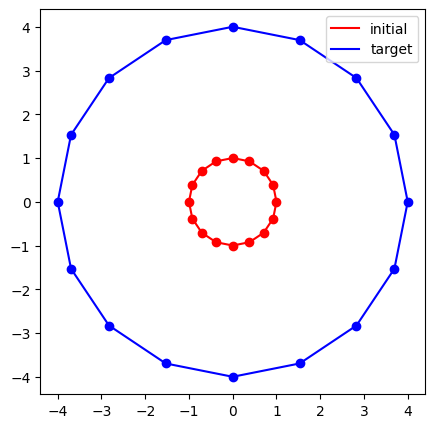

In [3]:
small_circle = Circle(r=1.0)
large_circle = Circle(r=4.0)

n_training_sample_pts = 16
small_circle_sample = small_circle.sample(n_training_sample_pts)
large_circle_sample = large_circle.sample(n_training_sample_pts)
print(f"initial condition shape: {small_circle_sample.shape}, target shape: {large_circle_sample.shape}")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = plot_shape_with_pts(ax, small_circle_sample, color='r', label='initial')
ax = plot_shape_with_pts(ax, large_circle_sample, color='b', label='target')
ax.set_aspect('equal')
ax.legend()

In [4]:
config = ConfigDict()

# Gaussian process
config.gp = ConfigDict()
config.gp.input_dim = 1
config.gp.output_dim = 2
config.gp.n_sample_pts = n_training_sample_pts
config.gp.kernel_type = "delta"
config.gp.sigma = 1.0
# config.gp.kappa = 0.02

# SDE
config.sde = ConfigDict()
config.sde.sigma = 1.0

# FNO
config.model = ConfigDict()
config.model.output_dim = 2
config.model.lifting_dims = [4, 8, 8, 8, 4]
config.model.max_n_modes = [4, 8, 8, 4]
config.model.activation = "relu"
config.model.time_embedding_dim = 32
config.model.time_incrop_method = "time_modulated"

# training
config.training = ConfigDict()
config.training.seed = 42
config.training.learning_rate = 1e-3
config.training.optimizer_name = "adam"
config.training.warmup_steps = 2000
config.training.train_batch_size = 64
config.training.train_num_epochs = 100
config.training.train_num_steps_per_epoch = 200

save_config(config, "./pretrained/configs/circles.yaml")

In [5]:
model = TimeDependentFNO1D(**config.model)
gp = GaussianProcess(**config.gp)
sde = BrownianSDE(**config.sde, gp=gp)

In [6]:
diffusion_loader = DiffusionLoader(
    sde, 
    seed=config.training.seed,
    init_cond=small_circle_sample,
    batch_size=config.training.train_batch_size,
    n_steps=100)

trainer = TrainerModule(
    config=config.training,
    model=model,
    dataloader=diffusion_loader,
    enable_wandb=False
)

In [7]:
trainer.train_model(
    pretrained=False,
    load_dir="/Users/vbd402/Documents/Projects/scoreoperator/pretrained/",
    prefix="circles"
)

Training: 100%|██████████| 100/100 [00:47<00:00,  2.11epoch/s, Epoch=99, eval_loss=0.0632, train_loss=0.0654]


In [8]:
def true_brownian_score(t, x, x0=small_circle_sample):
    mean, std = sde._transition_prob(t, x, x0)
    return  -(x - mean) / (std + 1e-4)**2

def est_brownian_score(t, x, x0=small_circle_sample):
    x_ = jnp.expand_dims(x, axis=0)
    t_ = jnp.expand_dims(t, axis=0)
    score = trainer.infer_model((x_, t_))
    return score.squeeze() 

In [9]:
class ReverseBrownianSDE(BrownianSDE):
    def __init__(self, sigma, gp, score_fn):
        super().__init__(gp, sigma)
        self._score_fn = score_fn

    def f(self, t, x):
        return self._sigma**2 * self._score_fn(1.0 - t, x)
    
    def g(self, t, x):
        return self._sigma * jnp.eye(x.shape[0])

In [10]:
n_eval_sample_pts = 64
score_fn = lambda t, x: est_brownian_score(t, x.reshape(-1, 2)).flatten()
# score_fn = lambda t, x: true_brownian_score(t, x.reshape(-1, 2), x0=small_circle.sample(n_eval_sample_pts)).flatten()

gp._n_sample_pts = n_eval_sample_pts
reverse_sde = ReverseBrownianSDE(sigma=config.sde.sigma, gp=gp, score_fn=score_fn)

In [11]:
drift = lambda t, y, args: reverse_sde.f(t, y)
diffusion = lambda t, y, args: reverse_sde.g(t, y)
brownian_motion = drx.VirtualBrownianTree(t0=0.0, t1=1.0, tol=1e-3, shape=((2*n_eval_sample_pts,)), key=jax.random.PRNGKey(4))
terms = drx.MultiTerm(drx.ODETerm(drift), drx.ControlTerm(diffusion, brownian_motion))
solver = drx.Euler()
saveat = drx.SaveAt(ts=jnp.linspace(0.0, 1.0, 500))
sol = drx.diffeqsolve(terms, solver, 0.0, 1.0, 1e-3, large_circle.sample(n_eval_sample_pts).flatten(), saveat=saveat)

Text(0.5, 1.0, '64 points')

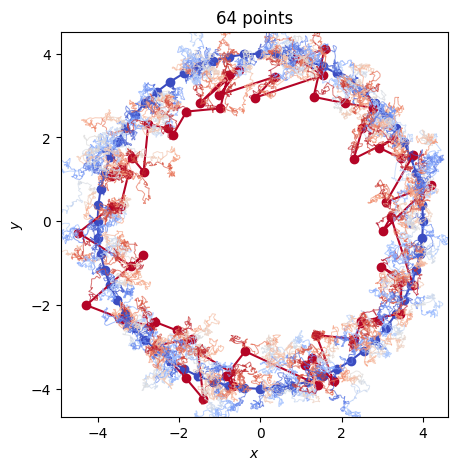

In [12]:
xs = sol.ys.reshape(-1, n_eval_sample_pts, 2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = plot_trajectories(ax, xs, target=small_circle_sample, cmap_name='coolwarm', plot_target=False)
ax.set_title(f"{n_eval_sample_pts} points")
# fig.savefig(f"./brownian_bridge_circles_{n_eval_sample_pts}pts_true.png", dpi=150, bbox_inches='tight')